In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
from typing import Union
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Seaborn, tqdm, Iprogress, ipywidgets

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## iNGEST

the dataset is gotten from [city of chicago website](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data)

In [3]:
# Ingest the data
def ingest_chicago_ridership():
    path = Path("datasets/ridership_new/CTA_-_Ridership_-_Daily_Boarding_Totals_20240528.csv")
    # read dataset
    df = pd.read_csv(path, parse_dates=["service_date"])
    # rename some columns
    df.rename(columns={
        "service_date": "date",
        "rail_boardings": "rail"
    }, inplace=True)
    # sort by date
    df = df.sort_values("date").set_index("date")
    # drop the duplicates
    df.drop_duplicates(keep='first', inplace=True)
    # index the data from 2020 till the end of the dataset
    df = df.loc["2020-1-1":]
    # the ferqunecy is daily
    df = df.asfreq("D")
    
    return df

In [4]:
df = ingest_chicago_ridership()
df.shape
df.head()

(1521, 4)

,day_type,bus,rail,total_rides
date,,,,
2020-01-01,U,267300,255759,523059
2020-01-02,W,651421,565139,1216560
2020-01-03,W,688165,578202,1266367
2020-01-04,A,409243,306656,715899
2020-01-05,U,314424,234155,548579


In [5]:
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29'],
              dtype='datetime64[ns]', name='date', length=1521, freq='D')

## Visualize

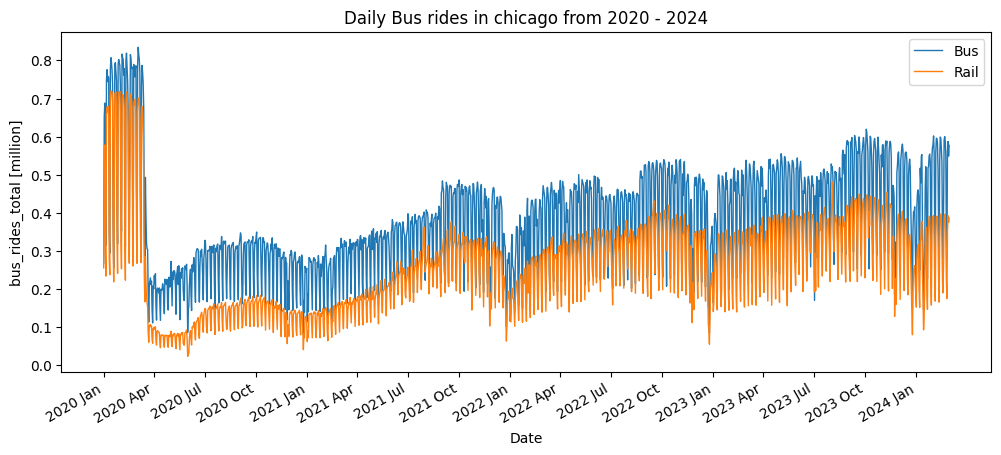

In [6]:
# The entire dataset as is
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df.index, df["bus"]/1e6, label="Bus", linestyle="-", linewidth=1)
ax.plot(df.index, df["rail"]/1e6, label="Rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("bus_rides_total [million]")
ax.set_title("Daily Bus rides in chicago from 2020 - 2024")

start_date = df.index[0]
end_date = df.index[-1]

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="QS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

ax.legend()
fig.autofmt_xdate();

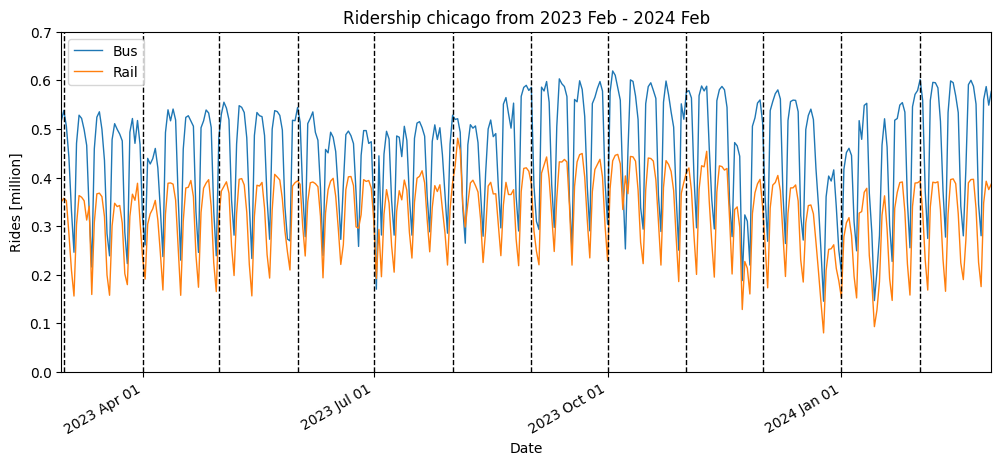

In [7]:
# From 2023 - 2024
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df.index, df["bus"]/1e6, label="Bus", linestyle="-", linewidth=1)
ax.plot(df.index, df["rail"]/1e6, label="Rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Rides [million]")
ax.set_title("Ridership chicago from 2023 Feb - 2024 Feb")

start_date = datetime(2023, 2, 28)
end_date = datetime(2024, 2, 29)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)
plt.ylim(0, 0.7)

for i in pd.date_range(start=start_date, end=end_date, freq="MS", inclusive='both'):
            ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="QS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))

ax.legend()
fig.autofmt_xdate();

## Train test split

Our main goal is to predict 14 days of data in in advance

+ The train set will be a year of data
+ The validation set will be 14 days of data
+ The test set will be 14 days of data

In [8]:
test_set_end = df.index[-1]
test_set_start = test_set_end - timedelta(13)
val_set_end = test_set_start - timedelta(1)
val_set_start = val_set_end - timedelta(13)
train_set_end = val_set_start - timedelta(1)
train_set_start = val_set_start - timedelta(356)

print(f"Train set: {train_set_start} - {train_set_end}")
print(f"Validation set: {val_set_start} - {val_set_end}")
print(f"Test set: {test_set_start} - {test_set_end}")

Train set: 2023-02-11 00:00:00 - 2024-02-01 00:00:00
Validation set: 2024-02-02 00:00:00 - 2024-02-15 00:00:00
Test set: 2024-02-16 00:00:00 - 2024-02-29 00:00:00


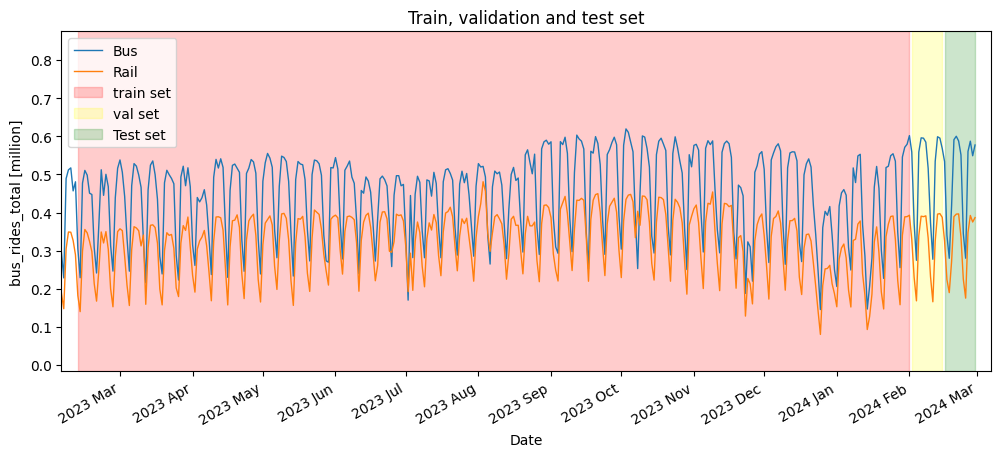

In [9]:
# Visualize it 
fig, ax = plt.subplots(figsize=(12, 5))

# Line plot
ax.plot(df.index, df["bus"]/1e6, label="Bus", linestyle="-", linewidth=1)
ax.plot(df.index, df["rail"]/1e6, label="Rail", linestyle="-", linewidth=1)

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("bus_rides_total [million]")
ax.set_title("Train, validation and test set")

start_date = train_set_start - timedelta(7)
end_date = test_set_end + timedelta(7)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)

ax.axvspan(train_set_start, train_set_end, color='red', alpha=0.2, label="train set") # Train set
ax.axvspan(val_set_start, val_set_end, color='yellow', alpha=0.2, label="val set") # Val set
ax.axvspan(test_set_start, test_set_end, color='green', alpha=0.2, label="Test set") # Test set

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="MS", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

ax.legend()
fig.autofmt_xdate();

In [10]:
# Now aggregate the train, validation and test set
train_set = df.loc[train_set_start:train_set_end]
val_set = df.loc[val_set_start:val_set_end]
test_set = df.loc[test_set_start:test_set_end]

train_set.shape, val_set.shape, test_set.shape

((356, 4), (14, 4), (14, 4))

In [11]:
# Confirm that the frequency is Daily. Statmodels will bring up a warning if this is not defined
assert train_set.index.freq == "D"
assert val_set.index.freq == "D"
assert test_set.index.freq == "D"

## Hyperparameter tuning with SARIMA  --- i.e without exogenous variables

In [12]:
def optimize_SARIMA(
    endog: Union[pd.Series, list], 
    # exog: Union[pd.Series, list], 
    order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            print(f"{order}: try block")
            model = SARIMAX(
                endog,
                # exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=0)
        except Exception as e:
            print(f"{order}: exception block: {e}")
            continue

        # AKIKE information criterion
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Tune For Bus

In [13]:
ps = range(0, 6, 1)
qs = range(0, 6, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 7

In [14]:
len(order_list)

576

In [15]:
SARIMA_result_df = optimize_SARIMA(train_set["bus"], order_list, d, D, s)

  0%|          | 0/576 [00:00<?, ?it/s]

(0, 0, 0, 0): try block
(0, 0, 0, 1): try block
(0, 0, 0, 2): try block


(0, 0, 0, 3): try block
(0, 0, 1, 0): try block
(0, 0, 1, 1): try block
(0, 0, 1, 2): try block
(0, 0, 1, 3): try block
(0, 0, 2, 0): try block
(0, 0, 2, 1): try block
(0, 0, 2, 2): try block
(0, 0, 2, 3): try block
(0, 0, 3, 0): try block
(0, 0, 3, 1): try block
(0, 0, 3, 2): try block
(0, 0, 3, 3): try block
(0, 1, 0, 0): try block
(0, 1, 0, 1): try block
(0, 1, 0, 2): try block
(0, 1, 0, 3): try block
(0, 1, 1, 0): try block
(0, 1, 1, 1): try block
(0, 1, 1, 2): try block
(0, 1, 1, 3): try block
(0, 1, 2, 0): try block
(0, 1, 2, 1): try block
(0, 1, 2, 2): try block
(0, 1, 2, 3): try block
(0, 1, 3, 0): try block
(0, 1, 3, 1): try block
(0, 1, 3, 2): try block
(0, 1, 3, 3): try block
(0, 2, 0, 0): try block
(0, 2, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 1, 0): try block
(0, 2, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 2, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 3, 0, 0): try block
(0, 3, 0, 1): try block
(0, 3, 0, 2): try block
(0, 3, 0, 3): try block
(0, 3, 1, 0): try block
(0, 3, 1, 1): try block
(0, 3, 1, 2): try block
(0, 3, 1, 3): try block
(0, 3, 2, 0): try block
(0, 3, 2, 1): try block
(0, 3, 2, 2): try block
(0, 3, 2, 3): try block
(0, 3, 3, 0): try block
(0, 3, 3, 1): try block
(0, 3, 3, 2): try block
(0, 3, 3, 3): try block
(0, 4, 0, 0): try block
(0, 4, 0, 1): try block
(0, 4, 0, 2): try block
(0, 4, 0, 3): try block
(0, 4, 1, 0): try block
(0, 4, 1, 1): try block
(0, 4, 1, 2): try block
(0, 4, 1, 3): try block
(0, 4, 2, 0): try block
(0, 4, 2, 1): try block
(0, 4, 2, 2): try block
(0, 4, 2, 3): try block
(0, 4, 3, 0): try block
(0, 4, 3, 1): try block
(0, 4, 3, 2): try block
(0, 4, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 5, 0, 0): try block
(0, 5, 0, 1): try block
(0, 5, 0, 2): try block
(0, 5, 0, 3): try block
(0, 5, 1, 0): try block
(0, 5, 1, 1): try block
(0, 5, 1, 2): try block
(0, 5, 1, 3): try block
(0, 5, 2, 0): try block
(0, 5, 2, 1): try block
(0, 5, 2, 2): try block
(0, 5, 2, 3): try block
(0, 5, 3, 0): try block
(0, 5, 3, 1): try block
(0, 5, 3, 2): try block
(0, 5, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 0, 0): try block
(1, 0, 0, 1): try block
(1, 0, 0, 2): try block
(1, 0, 0, 3): try block
(1, 0, 1, 0): try block
(1, 0, 1, 1): try block
(1, 0, 1, 2): try block
(1, 0, 1, 3): try block
(1, 0, 2, 0): try block
(1, 0, 2, 1): try block
(1, 0, 2, 2): try block
(1, 0, 2, 3): try block
(1, 0, 3, 0): try block
(1, 0, 3, 1): try block
(1, 0, 3, 2): try block
(1, 0, 3, 3): try block
(1, 1, 0, 0): try block
(1, 1, 0, 1): try block
(1, 1, 0, 2): try block
(1, 1, 0, 3): try block
(1, 1, 1, 0): try block
(1, 1, 1, 1): try block
(1, 1, 1, 2): try block
(1, 1, 1, 3): try block
(1, 1, 2, 0): try block
(1, 1, 2, 1): try block
(1, 1, 2, 2): try block
(1, 1, 2, 3): try block
(1, 1, 3, 0): try block
(1, 1, 3, 1): try block
(1, 1, 3, 2): try block
(1, 1, 3, 3): try block
(1, 2, 0, 0): try block
(1, 2, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 3, 0, 0): try block
(1, 3, 0, 1): try block
(1, 3, 0, 2): try block
(1, 3, 0, 3): try block
(1, 3, 1, 0): try block
(1, 3, 1, 1): try block
(1, 3, 1, 2): try block
(1, 3, 1, 3): try block
(1, 3, 2, 0): try block
(1, 3, 2, 1): try block
(1, 3, 2, 2): try block
(1, 3, 2, 3): try block
(1, 3, 3, 0): try block
(1, 3, 3, 1): try block
(1, 3, 3, 2): try block
(1, 3, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 4, 0, 0): try block
(1, 4, 0, 1): try block
(1, 4, 0, 2): try block
(1, 4, 0, 3): try block
(1, 4, 1, 0): try block
(1, 4, 1, 1): try block
(1, 4, 1, 2): try block
(1, 4, 1, 3): try block
(1, 4, 2, 0): try block
(1, 4, 2, 1): try block
(1, 4, 2, 2): try block
(1, 4, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 4, 3, 0): try block
(1, 4, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 4, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 4, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 5, 0, 0): try block
(1, 5, 0, 1): try block
(1, 5, 0, 2): try block
(1, 5, 0, 3): try block
(1, 5, 1, 0): try block
(1, 5, 1, 1): try block
(1, 5, 1, 2): try block
(1, 5, 1, 3): try block
(1, 5, 2, 0): try block
(1, 5, 2, 1): try block
(1, 5, 2, 2): try block
(1, 5, 2, 3): try block
(1, 5, 3, 0): try block
(1, 5, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 5, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 5, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 0, 0): try block
(2, 0, 0, 1): try block
(2, 0, 0, 2): try block
(2, 0, 0, 3): try block
(2, 0, 1, 0): try block
(2, 0, 1, 1): try block
(2, 0, 1, 2): try block
(2, 0, 1, 3): try block
(2, 0, 2, 0): try block
(2, 0, 2, 1): try block
(2, 0, 2, 2): try block
(2, 0, 2, 3): try block
(2, 0, 3, 0): try block
(2, 0, 3, 1): try block
(2, 0, 3, 2): try block
(2, 0, 3, 3): try block
(2, 1, 0, 0): try block
(2, 1, 0, 1): try block
(2, 1, 0, 2): try block
(2, 1, 0, 3): try block
(2, 1, 1, 0): try block
(2, 1, 1, 1): try block
(2, 1, 1, 2): try block
(2, 1, 1, 3): try block
(2, 1, 2, 0): try block
(2, 1, 2, 1): try block
(2, 1, 2, 2): try block
(2, 1, 2, 3): try block
(2, 1, 3, 0): try block
(2, 1, 3, 1): try block
(2, 1, 3, 2): try block
(2, 1, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 0, 0): try block
(2, 2, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 2, 0, 3): try block
(2, 2, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 2, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 2, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 2, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 2, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 2, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 2, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 1, 0): try block
(2, 3, 1, 1): try block
(2, 3, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 3, 0): try block
(2, 3, 3, 1): try block
(2, 3, 3, 2): try block
(2, 3, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 1, 0): try block
(2, 4, 1, 1): try block
(2, 4, 1, 2): try block
(2, 4, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 2, 0): try block
(2, 4, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 2, 2): try block
(2, 4, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 3, 1): try block
(2, 4, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 4, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 1, 0): try block
(2, 5, 1, 1): try block
(2, 5, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 2, 0): try block
(2, 5, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 3, 0): try block
(2, 5, 3, 1): try block
(2, 5, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 5, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 0, 0): try block
(3, 0, 0, 1): try block
(3, 0, 0, 2): try block
(3, 0, 0, 3): try block
(3, 0, 1, 0): try block
(3, 0, 1, 1): try block
(3, 0, 1, 2): try block
(3, 0, 1, 3): try block
(3, 0, 2, 0): try block
(3, 0, 2, 1): try block
(3, 0, 2, 2): try block
(3, 0, 2, 3): try block
(3, 0, 3, 0): try block
(3, 0, 3, 1): try block
(3, 0, 3, 2): try block
(3, 0, 3, 3): try block
(3, 1, 0, 0): try block
(3, 1, 0, 1): try block
(3, 1, 0, 2): try block
(3, 1, 0, 3): try block
(3, 1, 1, 0): try block
(3, 1, 1, 1): try block
(3, 1, 1, 2): try block
(3, 1, 1, 3): try block
(3, 1, 2, 0): try block
(3, 1, 2, 1): try block
(3, 1, 2, 2): try block
(3, 1, 2, 3): try block
(3, 1, 3, 0): try block
(3, 1, 3, 1): try block
(3, 1, 3, 2): try block
(3, 1, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 0, 0): try block
(3, 2, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 2, 1, 2): try block
(3, 2, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 2, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 3, 0): try block
(3, 2, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 2, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 1, 1): try block
(3, 3, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 1, 3): try block
(3, 3, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 3, 0): try block
(3, 3, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 3, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 1, 0): try block
(3, 4, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 4, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 1, 2): try block
(3, 5, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 5, 3, 2): try block
(3, 5, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 0, 0): try block
(4, 0, 0, 1): try block
(4, 0, 0, 2): try block
(4, 0, 0, 3): try block
(4, 0, 1, 0): try block
(4, 0, 1, 1): try block
(4, 0, 1, 2): try block
(4, 0, 1, 3): try block
(4, 0, 2, 0): try block
(4, 0, 2, 1): try block
(4, 0, 2, 2): try block
(4, 0, 2, 3): try block
(4, 0, 3, 0): try block
(4, 0, 3, 1): try block
(4, 0, 3, 2): try block
(4, 0, 3, 3): try block
(4, 1, 0, 0): try block
(4, 1, 0, 1): try block
(4, 1, 0, 2): try block
(4, 1, 0, 3): try block
(4, 1, 1, 0): try block
(4, 1, 1, 1): try block
(4, 1, 1, 2): try block
(4, 1, 1, 3): try block
(4, 1, 2, 0): try block
(4, 1, 2, 1): try block
(4, 1, 2, 2): try block
(4, 1, 2, 3): try block
(4, 1, 3, 0): try block
(4, 1, 3, 1): try block
(4, 1, 3, 2): try block
(4, 1, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 2, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(4, 2, 1, 1): try block
(4, 2, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(4, 2, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 3, 0): try block
(4, 2, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 2, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(4, 2, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 3, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 4, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 5, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 0, 0): try block
(5, 0, 0, 1): try block
(5, 0, 0, 2): try block
(5, 0, 0, 3): try block
(5, 0, 1, 0): try block
(5, 0, 1, 1): try block
(5, 0, 1, 2): try block
(5, 0, 1, 3): try block
(5, 0, 2, 0): try block
(5, 0, 2, 1): try block
(5, 0, 2, 2): try block
(5, 0, 2, 3): try block
(5, 0, 3, 0): try block
(5, 0, 3, 1): try block
(5, 0, 3, 2): try block
(5, 0, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 0, 0): try block
(5, 1, 0, 1): try block
(5, 1, 0, 2): try block
(5, 1, 0, 3): try block
(5, 1, 1, 0): try block
(5, 1, 1, 1): try block
(5, 1, 1, 2): try block
(5, 1, 1, 3): try block
(5, 1, 2, 0): try block
(5, 1, 2, 1): try block
(5, 1, 2, 2): try block
(5, 1, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 3, 0): try block
(5, 1, 3, 1): try block
(5, 1, 3, 2): try block
(5, 1, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 0, 2): try block
(5, 2, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 2, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 2, 0): try block
(5, 2, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 2, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 3, 0): try block
(5, 2, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 2, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 2, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 0, 0): try block
(5, 3, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 0, 2): try block
(5, 3, 0, 3): try block
(5, 3, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 3, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 4, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 0, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 0, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 0, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 0, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 1, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 1, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 1, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 1, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 2, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 2, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 2, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 2, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 3, 0): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 3, 1): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 3, 2): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 5, 3, 3): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(4, 2, 2, 2)",8800.627119
1,"(4, 2, 3, 3)",8801.038542
2,"(4, 2, 3, 2)",8802.625840
3,"(5, 2, 2, 2)",8802.777853
4,"(4, 2, 2, 3)",8802.850850
...,...,...
571,"(3, 0, 0, 0)",9257.143746
572,"(2, 0, 0, 0)",9266.372181
573,"(0, 0, 0, 0)",9295.938742
574,"(0, 1, 0, 0)",9297.628627


Statistical models falter when the dataset it very large

When d=0, these are the top 5 results
|    | (p,q,P,Q)     | AIC         |
|----|---------------|-------------|
| 0  | (5, 4, 2, 0)  | 24.000000   |
| 1  | (5, 3, 2, 2)  | 8814.904850 |
| 2  | (5, 3, 1, 2)  | 8815.428659 |
| 3  | (5, 3, 1, 1)  | 8815.439785 |
| 4  | (5, 3, 2, 1)  | 8815.768282 |


When d=1, these are the results
|    | (p,q,P,Q)     | AIC         |
|----|---------------|-------------|
| 0  | (4, 2, 2, 2)  | 8800.627119 |
| 1  | (4, 2, 3, 3)  | 8801.038542 |
| 2  | (4, 2, 3, 2)  | 8802.625840 |
| 3  | (5, 2, 2, 2)  | 8802.777853 |
| 4  | (4, 2, 2, 3)  | 8802.850850 |

In [20]:
# Train the model
best_model = SARIMAX(train_set["bus"], order=(4,1,2), seasonal_order=(2, 0, 2, 7), simple_differencing=False).fit(disp=0)

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
best_model.aic

8800.627118946402

In [22]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               bus   No. Observations:                  356
Model:             SARIMAX(4, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -4389.314
Date:                           Fri, 07 Jun 2024   AIC                           8800.627
Time:                                   15:37:35   BIC                           8843.220
Sample:                               02-11-2023   HQIC                          8817.572
                                    - 02-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4860      0.070     -6.955      0.000      -0.623      -0.349
ar.L2          0.5858      0.068      8.595

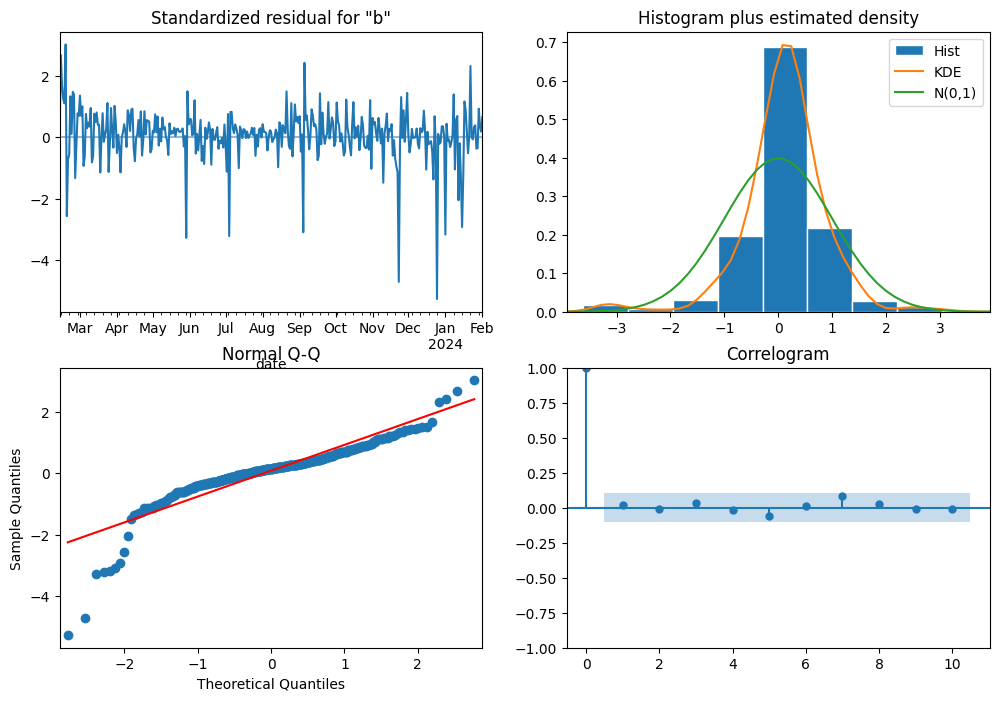

In [23]:
# Perform residual analysis
best_model.plot_diagnostics(figsize=(12,8));

In [26]:
residuals = best_model.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,1.513408,0.218620
2,4.060414,0.131308
3,6.531175,0.088441
4,6.880287,0.142351
5,7.784003,0.168548
6,9.496249,0.147532
7,10.259980,0.174313
8,10.509974,0.231039
9,10.600932,0.304057
10,10.935243,0.362585


### Tune for Rail

In [12]:
def optimize_SARIMA(
    endog: Union[pd.Series, list], 
    order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            print(f"{order}: try block")
            model = SARIMAX(
                endog,
                # exog,
                order=(order[0], order[1], order[2]),
                seasonal_order=(order[3], order[4], order[5], order[6]),
                simple_differencing=False).fit(disp=0)
        except Exception as e:
            print(f"{order}: exception block: {e}")
            continue

        # AKIKE information criterion
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q, P,D,Q,s)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [13]:
ps = range(0, 6, 1)
ds = range(0, 2, 1)
qs = range(0, 6, 1)

Ps = range(0, 4, 1)
Ds = [0]
Qs = range(0, 4, 1)
ss = [7]

order_list = list(product(ps, ds, qs, Ps, Ds, Qs, ss))

D = 0
s = 7

len(order_list)

1152

In [15]:
SARIMA_result_df = optimize_SARIMA(train_set["rail"], order_list)

  0%|          | 0/1152 [00:00<?, ?it/s]

(0, 0, 0, 0, 0, 0, 7): try block
(0, 0, 0, 0, 0, 1, 7): try block
(0, 0, 0, 0, 0, 2, 7): try block


(0, 0, 0, 0, 0, 3, 7): try block
(0, 0, 0, 1, 0, 0, 7): try block
(0, 0, 0, 1, 0, 1, 7): try block
(0, 0, 0, 1, 0, 2, 7): try block
(0, 0, 0, 1, 0, 3, 7): try block
(0, 0, 0, 2, 0, 0, 7): try block
(0, 0, 0, 2, 0, 1, 7): try block
(0, 0, 0, 2, 0, 2, 7): try block
(0, 0, 0, 2, 0, 3, 7): try block
(0, 0, 0, 3, 0, 0, 7): try block
(0, 0, 0, 3, 0, 1, 7): try block
(0, 0, 0, 3, 0, 2, 7): try block
(0, 0, 0, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 0, 0, 0, 7): try block
(0, 0, 1, 0, 0, 1, 7): try block
(0, 0, 1, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 0, 0, 3, 7): try block
(0, 0, 1, 1, 0, 0, 7): try block
(0, 0, 1, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2, 0, 0, 0, 7): try block
(0, 0, 2, 0, 0, 1, 7): try block
(0, 0, 2, 0, 0, 2, 7): try block
(0, 0, 2, 0, 0, 3, 7): try block
(0, 0, 2, 1, 0, 0, 7): try block
(0, 0, 2, 1, 0, 1, 7): try block
(0, 0, 2, 1, 0, 2, 7): try block
(0, 0, 2, 1, 0, 3, 7): try block
(0, 0, 2, 2, 0, 0, 7): try block
(0, 0, 2, 2, 0, 1, 7): try block
(0, 0, 2, 2, 0, 2, 7): try block
(0, 0, 2, 2, 0, 3, 7): try block
(0, 0, 2, 3, 0, 0, 7): try block
(0, 0, 2, 3, 0, 1, 7): try block
(0, 0, 2, 3, 0, 2, 7): try block
(0, 0, 2, 3, 0, 3, 7): try block
(0, 0, 3, 0, 0, 0, 7): try block
(0, 0, 3, 0, 0, 1, 7): try block
(0, 0, 3, 0, 0, 2, 7): try block
(0, 0, 3, 0, 0, 3, 7): try block
(0, 0, 3, 1, 0, 0, 7): try block
(0, 0, 3, 1, 0, 1, 7): try block
(0, 0, 3, 1, 0, 2, 7): try block
(0, 0, 3, 1, 0, 3, 7): try block
(0, 0, 3, 2, 0, 0, 7): try block
(0, 0, 3, 2, 0, 1, 7): try block
(0, 0, 3, 2, 0, 2, 7): try block
(0, 0, 3, 2, 0, 3, 7): try block
(0, 0, 3, 3, 0, 0, 7): try block
(0, 0, 3, 3, 0, 1, 7): try block
(0, 0, 3, 

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 1, 0, 0, 7): try block
(0, 1, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 3, 0, 0, 0, 7): try block
(0, 1, 3, 0, 0, 1, 7): try block
(0, 1, 3, 0, 0, 2, 7): try block
(0, 1, 3, 0, 0, 3, 7): try block
(0, 1, 3, 1, 0, 0, 7): try block
(0, 1, 3, 1, 0, 1, 7): try block
(0, 1, 3, 1, 0, 2, 7): try block
(0, 1, 3, 1, 0, 3, 7): try block
(0, 1, 3, 2, 0, 0, 7): try block
(0, 1, 3, 2, 0, 1, 7): try block
(0, 1, 3, 2, 0, 2, 7): try block
(0, 1, 3, 2, 0, 3, 7): try block
(0, 1, 3, 3, 0, 0, 7): try block
(0, 1, 3, 3, 0, 1, 7): try block
(0, 1, 3, 3, 0, 2, 7): try block
(0, 1, 3, 3, 0, 3, 7): try block
(0, 1, 4, 0, 0, 0, 7): try block
(0, 1, 4, 0, 0, 1, 7): try block
(0, 1, 4, 0, 0, 2, 7): try block
(0, 1, 4, 0, 0, 3, 7): try block
(0, 1, 4, 1, 0, 0, 7): try block
(0, 1, 4, 1, 0, 1, 7): try block
(0, 1, 4, 1, 0, 2, 7): try block
(0, 1, 4, 1, 0, 3, 7): try block
(0, 1, 4, 2, 0, 0, 7): try block
(0, 1, 4, 2, 0, 1, 7): try block
(0, 1, 4, 2, 0, 2, 7): try block
(0, 1, 4, 2, 0, 3, 7): try block
(0, 1, 4, 3, 0, 0, 7): try block
(0, 1, 4, 3, 0, 1, 7): try block
(0, 1, 4, 

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2, 2, 0, 3, 7): try block
(1, 0, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2, 3, 0, 1, 7): try block
(1, 0, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 0, 0, 0, 7): try block
(1, 0, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 4, 0, 0, 0, 7): try block
(1, 0, 4, 0, 0, 1, 7): try block
(1, 0, 4, 0, 0, 2, 7): try block
(1, 0, 4, 0, 0, 3, 7): try block
(1, 0, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 4, 1, 0, 1, 7): try block
(1, 0, 4, 1, 0, 2, 7): try block
(1, 0, 4, 1, 0, 3, 7): try block
(1, 0, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 4, 2, 0, 1, 7): try block
(1, 0, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 4, 2, 0, 3, 7): try block
(1, 0, 4, 3, 0, 0, 7): try block
(1, 0, 4, 3, 0, 1, 7): try block
(1, 0, 4, 3, 0, 2, 7): try block
(1, 0, 4, 3, 0, 3, 7): try block
(1, 0, 5, 0, 0, 0, 7): try block
(1, 0, 5, 0, 0, 1, 7): try block
(1, 0, 5, 0, 0, 2, 7): try block
(1, 0, 5, 0, 0, 3, 7): try block
(1, 0, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 5, 1, 0, 1, 7): try block
(1, 0, 5, 1, 0, 2, 7): try block
(1, 0, 5, 1, 0, 3, 7): try block
(1, 0, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 5, 2, 0, 1, 7): try block
(1, 0, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 5, 3, 0, 0, 7): try block
(1, 0, 5, 3, 0, 1, 7): try block
(1, 0, 5, 3, 0, 2, 7): try block
(1, 0, 5, 3, 0, 3, 7): try block
(1, 1, 0, 0, 0, 0, 7): try block
(1, 1, 0, 0, 0, 1, 7): try block
(1, 1, 0, 0, 0, 2, 7): try block
(1, 1, 0, 0, 0, 3, 7): try block
(1, 1, 0, 1, 0, 0, 7): try block
(1, 1, 0, 1, 0, 1, 7): try block
(1, 1, 0, 1, 0, 2, 7): try block
(1, 1, 0, 1, 0, 3, 7): try block
(1, 1, 0, 2, 0, 0, 7): try block
(1, 1, 0, 2, 0, 1, 7): try block
(1, 1, 0, 2, 0, 2, 7): try block
(1, 1, 0, 2, 0, 3, 7): try block
(1, 1, 0, 3, 0, 0, 7): try block
(1, 1, 0, 3, 0, 1, 7): try block
(1, 1, 0, 3, 0, 2, 7): try block
(1, 1, 0, 3, 0, 3, 7): try block
(1, 1, 1, 0, 0, 0, 7): try block
(1, 1, 1, 0, 0, 1, 7): try block
(1, 1, 1, 0, 0, 2, 7): try block
(1, 1, 1, 0, 0, 3, 7): try block
(1, 1, 1, 1, 0, 0, 7): try block
(1, 1, 1, 1, 0, 1, 7): try block
(1, 1, 1, 1, 0, 2, 7): try block
(1, 1, 1, 1, 0, 3, 7): try block
(1, 1, 1, 2, 0, 0, 7): try block
(1, 1, 1, 2, 0, 1, 7): try block
(1, 1, 1, 

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 1, 0, 3, 7): try block
(1, 1, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 3, 0, 0, 7): try block
(1, 1, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3, 0, 0, 0, 7): try block
(1, 1, 3, 0, 0, 1, 7): try block
(1, 1, 3, 0, 0, 2, 7): try block
(1, 1, 3, 0, 0, 3, 7): try block
(1, 1, 3, 1, 0, 0, 7): try block
(1, 1, 3, 1, 0, 1, 7): try block
(1, 1, 3, 1, 0, 2, 7): try block
(1, 1, 3, 1, 0, 3, 7): try block
(1, 1, 3, 2, 0, 0, 7): try block
(1, 1, 3, 2, 0, 1, 7): try block
(1, 1, 3, 2, 0, 2, 7): try block
(1, 1, 3, 2, 0, 3, 7): try block
(1, 1, 3, 3, 0, 0, 7): try block
(1, 1, 3, 3, 0, 1, 7): try block
(1, 1, 3, 3, 0, 2, 7): try block
(1, 1, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 4, 0, 0, 0, 7): try block
(1, 1, 4, 0, 0, 1, 7): try block
(1, 1, 4, 0, 0, 2, 7): try block
(1, 1, 4, 0, 0, 3, 7): try block
(1, 1, 4, 1, 0, 0, 7): try block
(1, 1, 4, 1, 0, 1, 7): try block
(1, 1, 4, 1, 0, 2, 7): try block
(1, 1, 4, 1, 0, 3, 7): try block
(1, 1, 4, 2, 0, 0, 7): try block
(1, 1, 4, 2, 0, 1, 7): try block
(1, 1, 4, 2, 0, 2, 7): try block
(1, 1, 4, 2, 0, 3, 7): try block
(1, 1, 4, 3, 0, 0, 7): try block
(1, 1, 4, 3, 0, 1, 7): try block
(1, 1, 4, 3, 0, 2, 7): try block
(1, 1, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 5, 0, 0, 0, 7): try block
(1, 1, 5, 0, 0, 1, 7): try block
(1, 1, 5, 0, 0, 2, 7): try block
(1, 1, 5, 0, 0, 3, 7): try block
(1, 1, 5, 1, 0, 0, 7): try block
(1, 1, 5, 1, 0, 1, 7): try block
(1, 1, 5, 1, 0, 2, 7): try block
(1, 1, 5, 1, 0, 3, 7): try block
(1, 1, 5, 2, 0, 0, 7): try block
(1, 1, 5, 2, 0, 1, 7): try block
(1, 1, 5, 2, 0, 2, 7): try block
(1, 1, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 5, 3, 0, 0, 7): try block
(1, 1, 5, 3, 0, 1, 7): try block
(1, 1, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 0, 0, 0, 0, 7): try block
(2, 0, 0, 0, 0, 1, 7): try block
(2, 0, 0, 0, 0, 2, 7): try block
(2, 0, 0, 0, 0, 3, 7): try block
(2, 0, 0, 1, 0, 0, 7): try block
(2, 0, 0, 1, 0, 1, 7): try block
(2, 0, 0, 1, 0, 2, 7): try block
(2, 0, 0, 1, 0, 3, 7): try block
(2, 0, 0, 2, 0, 0, 7): try block
(2, 0, 0, 2, 0, 1, 7): try block
(2, 0, 0, 2, 0, 2, 7): try block
(2, 0, 0, 2, 0, 3, 7): try block
(2, 0, 0, 3, 0, 0, 7): try block
(2, 0, 0, 3, 0, 1, 7): try block
(2, 0, 0, 3, 0, 2, 7): try block
(2, 0, 0, 3, 0, 3, 7): try block
(2, 0, 1, 0, 0, 0, 7): try block
(2, 0, 1, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramete

(2, 0, 1, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 0, 1, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 3, 0, 0, 7): try block
(2, 0, 1, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 0, 1, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 0, 0, 0, 7): try block
(2, 0, 2, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 0, 2, 2, 0, 0, 7): try block
(2, 0, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 0, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 3, 0, 0, 7): try block
(2, 0, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 0, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 0, 0, 0, 7): try block
(2, 0, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 0, 0, 2, 7): try block
(2, 0, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 1, 0, 1, 7): try block
(2, 0, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 2, 0, 1, 7): try block
(2, 0, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 3, 0, 1, 7): try block
(2, 0, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 0, 0, 0, 7): try block
(2, 0, 4, 0, 0, 1, 7): try block
(2, 0, 4, 0, 0, 2, 7): try block
(2, 0, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 1, 0, 1, 7): try block
(2, 0, 4, 1, 0, 2, 7): try block
(2, 0, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 2, 0, 1, 7): try block
(2, 0, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 2, 0, 3, 7): try block
(2, 0, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 4, 3, 0, 1, 7): try block
(2, 0, 4, 3, 0, 2, 7): try block
(2, 0, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5, 0, 0, 0, 7): try block
(2, 0, 5, 0, 0, 1, 7): try block
(2, 0, 5, 0, 0, 2, 7): try block
(2, 0, 5, 0, 0, 3, 7): try block
(2, 0, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5, 1, 0, 1, 7): try block
(2, 0, 5, 1, 0, 2, 7): try block
(2, 0, 5, 1, 0, 3, 7): try block
(2, 0, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5, 2, 0, 1, 7): try block
(2, 0, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5, 2, 0, 3, 7): try block
(2, 0, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5, 3, 0, 1, 7): try block
(2, 0, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 0, 0, 0, 7): try block
(2, 1, 0, 0, 0, 1, 7): try block
(2, 1, 0, 0, 0, 2, 7): try block
(2, 1, 0, 0, 0, 3, 7): try block
(2, 1, 0, 1, 0, 0, 7): try block
(2, 1, 0, 1, 0, 1, 7): try block
(2, 1, 0, 1, 0, 2, 7): try block
(2, 1, 0, 1, 0, 3, 7): try block
(2, 1, 0, 2, 0, 0, 7): try block
(2, 1, 0, 2, 0, 1, 7): try block
(2, 1, 0, 2, 0, 2, 7): try block
(2, 1, 0, 2, 0, 3, 7): try block
(2, 1, 0, 3, 0, 0, 7): try block
(2, 1, 0, 3, 0, 1, 7): try block
(2, 1, 0, 3, 0, 2, 7): try block
(2, 1, 0, 3, 0, 3, 7): try block
(2, 1, 1, 0, 0, 0, 7): try block
(2, 1, 1, 0, 0, 1, 7): try block
(2, 1, 1, 0, 0, 2, 7): try block
(2, 1, 1, 0, 0, 3, 7): try block
(2, 1, 1, 1, 0, 0, 7): try block
(2, 1, 1, 1, 0, 1, 7): try block
(2, 1, 1, 1, 0, 2, 7): try block
(2, 1, 1, 1, 0, 3, 7): try block
(2, 1, 1, 2, 0, 0, 7): try block
(2, 1, 1, 2, 0, 1, 7): try block
(2, 1, 1, 2, 0, 2, 7): try block
(2, 1, 1, 2, 0, 3, 7): try block
(2, 1, 1, 3, 0, 0, 7): try block
(2, 1, 1, 3, 0, 1, 7): try block
(2, 1, 1, 

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 1, 2, 2, 0, 1, 7): try block
(2, 1, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 1, 2, 2, 0, 3, 7): try block
(2, 1, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(2, 1, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 0, 0, 1, 7): try block
(2, 1, 3, 0, 0, 2, 7): try block
(2, 1, 3, 0, 0, 3, 7): try block
(2, 1, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 1, 0, 3, 7): try block
(2, 1, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 2, 0, 2, 7): try block
(2, 1, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 3, 0, 1, 7): try block
(2, 1, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 1, 0, 0, 7): try block
(2, 1, 5, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 3, 0, 0, 7): try block
(2, 1, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 0, 0, 0, 0, 7): try block
(3, 0, 0, 0, 0, 1, 7): try block
(3, 0, 0, 0, 0, 2, 7): try block
(3, 0, 0, 0, 0, 3, 7): try block
(3, 0, 0, 1, 0, 0, 7): try block
(3, 0, 0, 1, 0, 1, 7): try block
(3, 0, 0, 1, 0, 2, 7): try block
(3, 0, 0, 1, 0, 3, 7): try block
(3, 0, 0, 2, 0, 0, 7): try block
(3, 0, 0, 2, 0, 1, 7): try block
(3, 0, 0, 2, 0, 2, 7): try block
(3, 0, 0, 2, 0, 3, 7): try block
(3, 0, 0, 3, 0, 0, 7): try block
(3, 0, 0, 3, 0, 1, 7): try block
(3, 0, 0, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 0, 3, 0, 3, 7): try block
(3, 0, 1, 0, 0, 0, 7): try block
(3, 0, 1, 0, 0, 1, 7): try block
(3, 0, 1, 0, 0, 2, 7): try block
(3, 0, 1, 0, 0, 3, 7): try block
(3, 0, 1, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 1, 0, 1, 7): try block
(3, 0, 1, 1, 0, 2, 7): try block
(3, 0, 1, 1, 0, 3, 7): try block
(3, 0, 1, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 2, 0, 1, 7): try block
(3, 0, 1, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 0, 0, 0, 7): try block
(3, 0, 2, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 0, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 0, 0, 3, 7): try block
(3, 0, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 0, 2, 2, 0, 1, 7): try block
(3, 0, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 0, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 0, 2, 3, 0, 1, 7): try block
(3, 0, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(3, 0, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 0, 0, 0, 7): try block
(3, 0, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 1, 0, 1, 7): try block
(3, 0, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 1, 0, 1, 7): try block
(3, 0, 4, 1, 0, 2, 7): try block
(3, 0, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 1, 0, 1, 7): try block
(3, 0, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 0, 0, 0, 0, 7): try block
(3, 1, 0, 0, 0, 1, 7): try block
(3, 1, 0, 0, 0, 2, 7): try block
(3, 1, 0, 0, 0, 3, 7): try block
(3, 1, 0, 1, 0, 0, 7): try block
(3, 1, 0, 1, 0, 1, 7): try block
(3, 1, 0, 1, 0, 2, 7): try block
(3, 1, 0, 1, 0, 3, 7): try block
(3, 1, 0, 2, 0, 0, 7): try block
(3, 1, 0, 2, 0, 1, 7): try block
(3, 1, 0, 2, 0, 2, 7): try block
(3, 1, 0, 2, 0, 3, 7): try block
(3, 1, 0, 3, 0, 0, 7): try block
(3, 1, 0, 3, 0, 1, 7): try block
(3, 1, 0, 3, 0, 2, 7): try block
(3, 1, 0, 3, 0, 3, 7): try block
(3, 1, 1, 0, 0, 0, 7): try block
(3, 1, 1, 0, 0, 1, 7): try block
(3, 1, 1, 0, 0, 2, 7): try block
(3, 1, 1, 0, 0, 3, 7): try block
(3, 1, 1, 1, 0, 0, 7): try block
(3, 1, 1, 1, 0, 1, 7): try block
(3, 1, 1, 1, 0, 2, 7): try block
(3, 1, 1, 1, 0, 3, 7): try block
(3, 1, 1, 2, 0, 0, 7): try block
(3, 1, 1, 2, 0, 1, 7): try block
(3, 1, 1, 2, 0, 2, 7): try block
(3, 1, 1, 2, 0, 3, 7): try block
(3, 1, 1, 3, 0, 0, 7): try block
(3, 1, 1, 3, 0, 1, 7): try block
(3, 1, 1, 

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 0, 0, 1, 7): try block
(3, 1, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 2, 0, 0, 7): try block
(3, 1, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 3, 0, 0, 7): try block
(3, 1, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 0, 0, 0, 0, 7): try block
(4, 0, 0, 0, 0, 1, 7): try block
(4, 0, 0, 0, 0, 2, 7): try block
(4, 0, 0, 0, 0, 3, 7): try block
(4, 0, 0, 1, 0, 0, 7): try block
(4, 0, 0, 1, 0, 1, 7): try block
(4, 0, 0, 1, 0, 2, 7): try block
(4, 0, 0, 1, 0, 3, 7): try block
(4, 0, 0, 2, 0, 0, 7): try block
(4, 0, 0, 2, 0, 1, 7): try block
(4, 0, 0, 2, 0, 2, 7): try block
(4, 0, 0, 2, 0, 3, 7): try block
(4, 0, 0, 3, 0, 0, 7): try block
(4, 0, 0, 3, 0, 1, 7): try block
(4, 0, 0, 3, 0, 2, 7): try block
(4, 0, 0, 3, 0, 3, 7): try block
(4, 0, 1, 0, 0, 0, 7): try block
(4, 0, 1, 0, 0, 1, 7): try block
(4, 0, 1, 0, 0, 2, 7): try block
(4, 0, 1, 0, 0, 3, 7): try block
(4, 0, 1, 1, 0, 0, 7): try block
(4, 0, 1, 1, 0, 1, 7): try block
(4, 0, 1, 1, 0, 2, 7): try block
(4, 0, 1, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 2, 0, 1, 7): try block
(4, 0, 1, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 0, 0, 1, 7): try block
(4, 0, 2, 0, 0, 1, 7): exception block: LU decomposition error.
(4, 0, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 1, 0, 2, 7): try block
(4, 0, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(4, 0, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 1, 0, 0, 7): try block
(4, 0, 3, 1, 0, 0, 7): exception block: LU decomposition error.
(4, 0, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 0, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 1, 0, 1, 7): try block
(4, 0, 4, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 0, 0, 0, 0, 7): try block
(4, 1, 0, 0, 0, 1, 7): try block
(4, 1, 0, 0, 0, 2, 7): try block
(4, 1, 0, 0, 0, 3, 7): try block
(4, 1, 0, 1, 0, 0, 7): try block
(4, 1, 0, 1, 0, 1, 7): try block
(4, 1, 0, 1, 0, 2, 7): try block
(4, 1, 0, 1, 0, 3, 7): try block
(4, 1, 0, 2, 0, 0, 7): try block
(4, 1, 0, 2, 0, 1, 7): try block
(4, 1, 0, 2, 0, 2, 7): try block
(4, 1, 0, 2, 0, 3, 7): try block
(4, 1, 0, 3, 0, 0, 7): try block
(4, 1, 0, 3, 0, 1, 7): try block
(4, 1, 0, 3, 0, 2, 7): try block
(4, 1, 0, 3, 0, 3, 7): try block
(4, 1, 1, 0, 0, 0, 7): try block
(4, 1, 1, 0, 0, 1, 7): try block
(4, 1, 1, 0, 0, 2, 7): try block
(4, 1, 1, 0, 0, 3, 7): try block
(4, 1, 1, 1, 0, 0, 7): try block
(4, 1, 1, 1, 0, 1, 7): try block
(4, 1, 1, 1, 0, 2, 7): try block
(4, 1, 1, 1, 0, 3, 7): try block
(4, 1, 1, 2, 0, 0, 7): try block
(4, 1, 1, 2, 0, 1, 7): try block
(4, 1, 1, 2, 0, 2, 7): try block
(4, 1, 1, 2, 0, 3, 7): try block
(4, 1, 1, 3, 0, 0, 7): try block
(4, 1, 1, 3, 0, 1, 7): try block
(4, 1, 1, 

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 0, 0, 1, 7): try block
(4, 1, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 1, 0, 0, 7): try block
(4, 1, 2, 1, 0, 0, 7): exception block: LU decomposition error.
(4, 1, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 2, 0, 1, 7): try block
(4, 1, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 3, 0, 1, 7): try block
(4, 1, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 0, 0, 0, 7): try block
(4, 1, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(4, 1, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 0, 0, 0, 7): try block
(4, 1, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 1, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 0, 0, 0, 0, 7): try block
(5, 0, 0, 0, 0, 1, 7): try block
(5, 0, 0, 0, 0, 2, 7): try block
(5, 0, 0, 0, 0, 3, 7): try block
(5, 0, 0, 1, 0, 0, 7): try block
(5, 0, 0, 1, 0, 1, 7): try block
(5, 0, 0, 1, 0, 2, 7): try block
(5, 0, 0, 1, 0, 3, 7): try block
(5, 0, 0, 2, 0, 0, 7): try block
(5, 0, 0, 2, 0, 1, 7): try block
(5, 0, 0, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 0, 2, 0, 3, 7): try block
(5, 0, 0, 3, 0, 0, 7): try block
(5, 0, 0, 3, 0, 1, 7): try block
(5, 0, 0, 3, 0, 2, 7): try block
(5, 0, 0, 3, 0, 3, 7): try block
(5, 0, 1, 0, 0, 0, 7): try block
(5, 0, 1, 0, 0, 1, 7): try block
(5, 0, 1, 0, 0, 2, 7): try block
(5, 0, 1, 0, 0, 3, 7): try block
(5, 0, 1, 1, 0, 0, 7): try block
(5, 0, 1, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 1, 1, 0, 2, 7): try block
(5, 0, 1, 1, 0, 3, 7): try block
(5, 0, 1, 2, 0, 0, 7): try block
(5, 0, 1, 2, 0, 1, 7): try block
(5, 0, 1, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 1, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 1, 3, 0, 0, 7): try block
(5, 0, 1, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 1, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 1, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 0, 0, 1, 7): try block
(5, 0, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 0, 2, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 1, 0, 3, 7): try block
(5, 0, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 0, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 0, 2, 3, 0, 3, 7): try block
(5, 0, 3, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 0, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 0, 0, 0, 0, 7): try block
(5, 1, 0, 0, 0, 1, 7): try block
(5, 1, 0, 0, 0, 2, 7): try block
(5, 1, 0, 0, 0, 3, 7): try block
(5, 1, 0, 1, 0, 0, 7): try block
(5, 1, 0, 1, 0, 1, 7): try block
(5, 1, 0, 1, 0, 2, 7): try block
(5, 1, 0, 1, 0, 3, 7): try block
(5, 1, 0, 2, 0, 0, 7): try block
(5, 1, 0, 2, 0, 1, 7): try block
(5, 1, 0, 2, 0, 2, 7): try block
(5, 1, 0, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 0, 3, 0, 0, 7): try block
(5, 1, 0, 3, 0, 1, 7): try block
(5, 1, 0, 3, 0, 2, 7): try block
(5, 1, 0, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 1, 0, 0, 0, 7): try block
(5, 1, 1, 0, 0, 1, 7): try block
(5, 1, 1, 0, 0, 2, 7): try block
(5, 1, 1, 0, 0, 3, 7): try block
(5, 1, 1, 1, 0, 0, 7): try block
(5, 1, 1, 1, 0, 1, 7): try block
(5, 1, 1, 1, 0, 2, 7): try block
(5, 1, 1, 1, 0, 3, 7): try block
(5, 1, 1, 2, 0, 0, 7): try block
(5, 1, 1, 2, 0, 1, 7): try block
(5, 1, 1, 2, 0, 2, 7): try block
(5, 1, 1, 2, 0, 3, 7): try block
(5, 1, 1, 3, 0, 0, 7): try block
(5, 1, 1, 3, 0, 1, 7): try block
(5, 1, 1, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 1, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 2, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 1, 2, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 0, 0, 3, 7): try block
(5, 1, 2, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 1, 2, 1, 0, 2, 7): try block
(5, 1, 2, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 1, 2, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 3, 0, 0, 7): try block
(5, 1, 2, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 2, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

(5, 1, 2, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 3, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 3, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 1, 3, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 4, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 0, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 0, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 0, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 0, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 1, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 1, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 1, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 1, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 2, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 2, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 2, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 2, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 3, 0, 0, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 3, 0, 1, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 3, 0, 2, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(5, 1, 5, 3, 0, 3, 7): try block


/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
SARIMA_result_df

,"(p,d,q, P,D,Q,s)",AIC
0,"(3, 1, 2, 2, 0, 2, 7)",8554.368637
1,"(3, 1, 2, 1, 0, 1, 7)",8554.512174
2,"(2, 1, 2, 2, 0, 2, 7)",8556.103625
3,"(4, 1, 2, 2, 0, 2, 7)",8556.114203
4,"(3, 1, 2, 3, 0, 2, 7)",8556.297885
...,...,...
1144,"(0, 0, 0, 0, 0, 3, 7)",9785.056769
1145,"(0, 0, 0, 0, 0, 2, 7)",9798.920208
1146,"(0, 0, 1, 0, 0, 0, 7)",9810.632854
1147,"(0, 0, 0, 0, 0, 1, 7)",9843.087897


|    | (p,d,q, P,D,Q,s)        | AIC         |
|----|-------------------------|-------------|
| 0  | (3, 1, 2, 2, 0, 2, 7)   | 8554.368637 |
| 1  | (3, 1, 2, 1, 0, 1, 7)   | 8554.512174 |
| 2  | (2, 1, 2, 2, 0, 2, 7)   | 8556.103625 |
| 3  | (4, 1, 2, 2, 0, 2, 7)   | 8556.114203 |
| 4  | (3, 1, 2, 3, 0, 2, 7)   | 8556.297885 |

In [28]:
# Train the modl
best_model = SARIMAX(train_set["rail"], order=(3,1,2), seasonal_order=(2,0,2,7) , simple_differencing=False).fit(disp=0)

/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/workspaces/chicago-ridership/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              rail   No. Observations:                  356
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -4267.184
Date:                           Sat, 08 Jun 2024   AIC                           8554.369
Time:                                   02:15:14   BIC                           8593.090
Sample:                               02-11-2023   HQIC                          8569.773
                                    - 02-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1624      1.090     -0.149      0.882      -2.299       1.974
ar.L2          0.4448      0.593      0.750

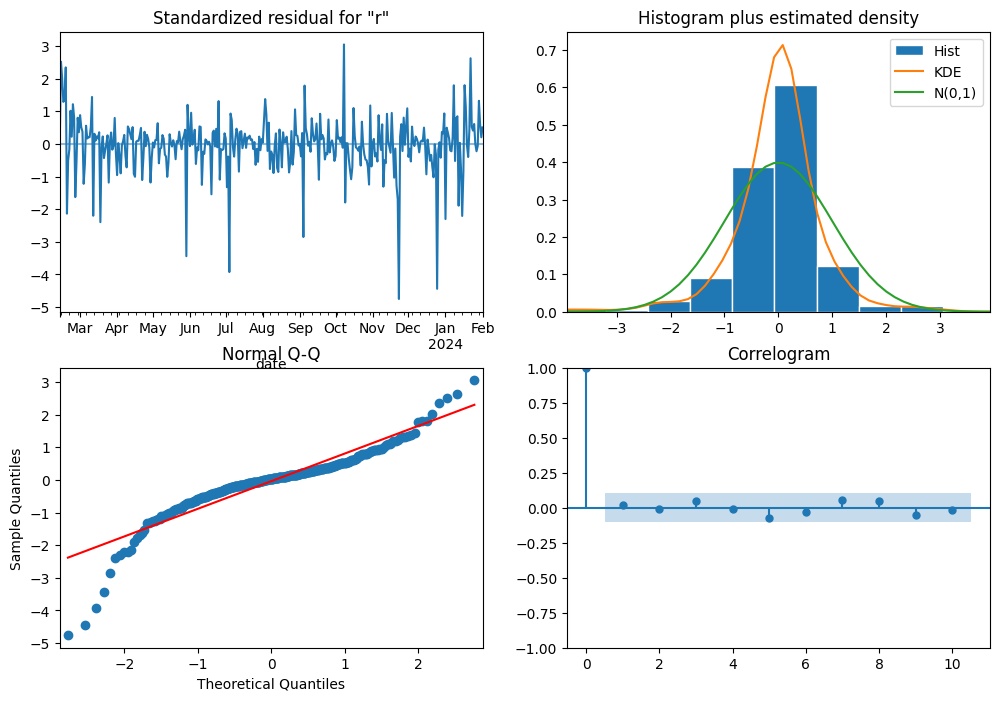

In [30]:
# Perform residual analysis
best_model.plot_diagnostics(figsize=(12,8));

In [31]:
residuals = best_model.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,1.454253,0.227847
2,3.012852,0.221701
3,6.390132,0.094098
4,6.640283,0.156163
5,7.561871,0.182092
6,7.740448,0.257742
7,8.157160,0.318940
8,8.948133,0.346690
9,9.710413,0.374434
10,9.769015,0.460987


## Training and Validation

Create separate dataframe for both the bus and rail in order to append the new predidtions from our various models

In [25]:
# Rail
rail_preds = val_set.loc[:, ["rail"]]
rail_preds.head()

# Bus
bus_preds = val_set.loc[:, ["bus"]]
bus_preds.head()

,rail
date,
2024-02-02,329307
2024-02-03,230410
2024-02-04,168339
2024-02-05,339256
2024-02-06,390513


,bus
date,
2024-02-02,558905
2024-02-03,372165
2024-02-04,274654
2024-02-05,558625
2024-02-06,595983


+ Baseline: Predict the next 14 days using value from the last 14 days.
+ Model1: Predict one day at a time.
+ Model2: Predict 2 days at a time.
+ Model3: Predict 7 days at a time.
+ Model4: Predict 14 days at once

### Baseline

+ Predict the next 14 days using value from the last 14 days.

In [26]:
baseline_end_date = train_set.index[-1]
baseline_start_date = baseline_end_date - timedelta(13)
print(f"The basline starts from {baseline_start_date} till {baseline_end_date}")

The basline starts from 2024-01-19 00:00:00 till 2024-02-01 00:00:00


In [27]:
bus_preds.loc[:, "last14values"] = train_set.loc[baseline_start_date:baseline_end_date, ["bus"]].values
bus_preds

,bus,last14values
date,,
2024-02-02,558905,462986
2024-02-03,372165,301556
2024-02-04,274654,227288
2024-02-05,558625,518106
2024-02-06,595983,521585
2024-02-07,595233,549204
2024-02-08,584729,554313
2024-02-09,515769,534739
2024-02-10,373420,349068


In [28]:
rail_preds.loc[:, "last14values"] = train_set.loc[baseline_start_date:baseline_end_date, ["rail"]].values
rail_preds

,rail,last14values
date,,
2024-02-02,329307,293650
2024-02-03,230410,191705
2024-02-04,168339,147028
2024-02-05,339256,336751
2024-02-06,390513,369664
2024-02-07,389227,389714
2024-02-08,391355,390971
2024-02-09,333453,329826
2024-02-10,231891,222033


### Model 2  - predict x days at a time

In [29]:
# Function for recursive forecast
def recursive_forecast(endog: Union[pd.Series, list], 
                       p: int, d:int, q:int, 
                       P: int, D:int, Q:int, S:int,
                       # exog: Union[pd.Series, list], 
                       train_len: int, 
                       horizon: int, 
                       window: int) -> list:
    
    total_len = train_len + horizon
  
    pred_SARIMAX = []
    
    for i in range(train_len, total_len, window):
        model = SARIMAX(
            endog[:i],
            # exog[:i],
            order=(p, d, q),
            seasonal_order=(P, D, Q, S),
            simple_differencing=False)
        res = model.fit(disp=False)
        predictions = res.get_forecast(steps=window)
        oos_pred = predictions.predicted_mean.values
        pred_SARIMAX.extend(oos_pred)
        
    return pred_SARIMAX

In [30]:
# The recursive forecast needs values from the train and validation dataset
train_val_set = pd.concat([train_set, val_set], axis=0)
train_val_set.shape
train_val_set.tail()

(370, 4)

,day_type,bus,rail,total_rides
date,,,,
2024-02-11,U,277432,165836,443268
2024-02-12,W,534181,325070,859251
2024-02-13,W,598961,395880,994841
2024-02-14,W,595347,397294,992641
2024-02-15,W,568392,387472,955864


In [31]:
TRAIN_LEN = len(train_set)
HORIZON = len(val_set)
WINDOW_1 = 1
WINDOW_2 = 2
WINDOW_7 = 7
WINDOW_14 = 14


TRAIN_LEN, HORIZON

(356, 14)

#### Bus

In [33]:
# predict one day at a time
bus_pred_sarima_1 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_1
                                      )
# bus_pred_sarima_1

bus_preds.loc[:, "SARIMA_1"] = bus_pred_sarima_1

In [35]:
# predict two days at a time
bus_pred_sarima_2 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_2
                                      )
# bus_pred_sarima_2
bus_preds.loc[:, "SARIMA_2"] = bus_pred_sarima_2

In [36]:
# predict 7 days at a time
bus_pred_sarima_7 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_7
                                      )
# bus_pred_sarima_7
bus_preds.loc[:, "SARIMA_7"] = bus_pred_sarima_7

In [37]:
# predict 14 days at a time
bus_pred_sarima_14 = recursive_forecast(train_val_set.loc[:, 'bus'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_14
                                      )
# bus_pred_sarima_14
bus_preds.loc[:, "SARIMA_14"] = bus_pred_sarima_14

In [38]:
bus_preds

,bus,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,558905,462986,532712.041243,532712.041243,532712.041243,532712.041243
2024-02-03,372165,301556,401276.265075,388899.695699,388899.695699,388899.695699
2024-02-04,274654,227288,292501.796276,292501.796276,295233.584445,295233.584445
2024-02-05,558625,518106,461496.995257,469939.898038,472332.027441,472332.027441
2024-02-06,595983,521585,548572.100124,548572.100124,513042.130363,513042.130363
2024-02-07,595233,549204,602579.838940,580538.552345,548826.269992,548826.269992
2024-02-08,584729,554313,592398.650734,592398.650734,548137.778784,548137.778784
2024-02-09,515769,534739,535757.676485,539340.948816,535757.676485,494770.045807
2024-02-10,373420,349068,376213.955648,376213.955648,385657.726401,356091.319049


#### Rail

In [39]:
rail_pred_sarima_1 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_1
                                      )
# rail_pred_sarima_1
rail_preds.loc[:, "SARIMA_1"] = rail_pred_sarima_1

/home/utility/jupyter/venvs/jupynote/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
rail_pred_sarima_2 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_2
                                      )
# rail_pred_sarima_2
rail_preds.loc[:, "SARIMA_2"] = rail_pred_sarima_2

In [41]:
rail_pred_sarima_7 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_7
                                      )
# rail_pred_sarima_7
rail_preds.loc[:, "SARIMA_7"] = rail_pred_sarima_7

In [42]:
rail_pred_sarima_14 = recursive_forecast(train_val_set.loc[:, 'rail'], 
                                       p=1, d=0, q=1, P=1, D=0, Q=1, S=7,
                                       train_len=TRAIN_LEN,
                                       horizon=HORIZON, 
                                       window=WINDOW_14
                                      )
# rail_pred_sarima_14
rail_preds.loc[:, "SARIMA_14"] = rail_pred_sarima_14

In [43]:
rail_preds

,rail,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,329307,293650,334889.181031,334889.181031,334889.181031,334889.181031
2024-02-03,230410,191705,245386.572299,248556.871162,248556.871162,248556.871162
2024-02-04,168339,147028,173763.235419,173763.235419,184905.316154,184905.316154
2024-02-05,339256,336751,280915.092143,283904.502606,293447.909753,293447.909753
2024-02-06,390513,369664,362009.490865,362009.490865,340860.109434,340860.109434
2024-02-07,389227,389714,399603.856893,383829.969843,365512.933513,365512.933513
2024-02-08,391355,390971,389981.810148,389981.810148,366385.587788,366385.587788
2024-02-09,333453,329826,332795.216757,332027.622469,332795.216757,312857.116099
2024-02-10,231891,222033,245005.652521,245005.652521,244639.406731,229918.330450


## Evaluation

In [44]:
rail_preds

,rail,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,329307,293650,334889.181031,334889.181031,334889.181031,334889.181031
2024-02-03,230410,191705,245386.572299,248556.871162,248556.871162,248556.871162
2024-02-04,168339,147028,173763.235419,173763.235419,184905.316154,184905.316154
2024-02-05,339256,336751,280915.092143,283904.502606,293447.909753,293447.909753
2024-02-06,390513,369664,362009.490865,362009.490865,340860.109434,340860.109434
2024-02-07,389227,389714,399603.856893,383829.969843,365512.933513,365512.933513
2024-02-08,391355,390971,389981.810148,389981.810148,366385.587788,366385.587788
2024-02-09,333453,329826,332795.216757,332027.622469,332795.216757,312857.116099
2024-02-10,231891,222033,245005.652521,245005.652521,244639.406731,229918.330450


In [45]:
bus_preds

,bus,last14values,SARIMA_1,SARIMA_2,SARIMA_7,SARIMA_14
date,,,,,,
2024-02-02,558905,462986,532712.041243,532712.041243,532712.041243,532712.041243
2024-02-03,372165,301556,401276.265075,388899.695699,388899.695699,388899.695699
2024-02-04,274654,227288,292501.796276,292501.796276,295233.584445,295233.584445
2024-02-05,558625,518106,461496.995257,469939.898038,472332.027441,472332.027441
2024-02-06,595983,521585,548572.100124,548572.100124,513042.130363,513042.130363
2024-02-07,595233,549204,602579.838940,580538.552345,548826.269992,548826.269992
2024-02-08,584729,554313,592398.650734,592398.650734,548137.778784,548137.778784
2024-02-09,515769,534739,535757.676485,539340.948816,535757.676485,494770.045807
2024-02-10,373420,349068,376213.955648,376213.955648,385657.726401,356091.319049


NameError: name 'rail_preds' is not defined

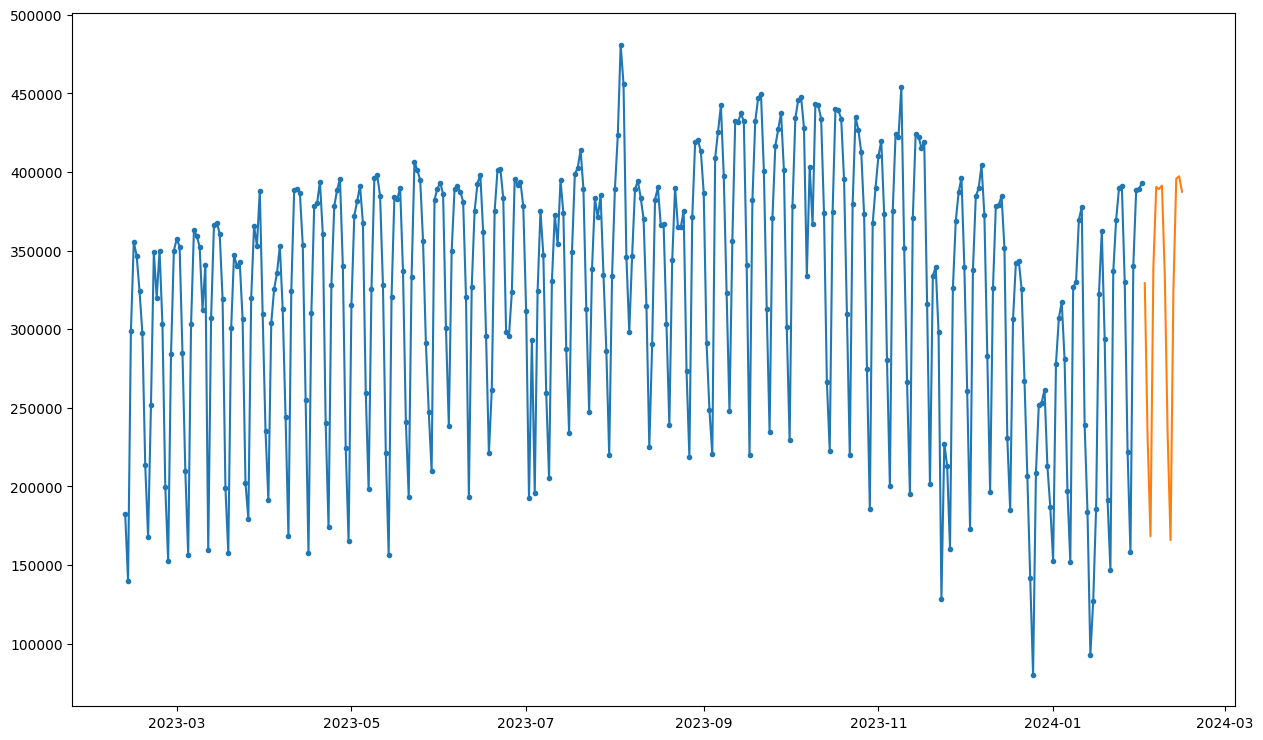

In [16]:
# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(train_set.rail, ".-", label="train")
ax.plot(val_set.rail, "-", label="validation")
ax.plot(rail_preds.last14values, "r:", label="baseline")
ax.plot(rail_preds.SARIMA_1, "k.-", label="sarima_1")
ax.plot(rail_preds.SARIMA_2, "k--", label="sarima_2")
ax.plot(rail_preds.SARIMA_7, "g--", label="sarima_7")
ax.plot(rail_preds.SARIMA_14, "g.-", label="sarima_14")

ax.set_xlabel('Date')
ax.set_ylabel('Rail Rides')

ax.axvspan(train_set_start, train_set_end, color='red', alpha=0.2, label="train set") # Train set
ax.axvspan(val_set_start, val_set_end, color='yellow', alpha=0.2, label="val set") # Val set


start_date = train_set_end - timedelta(10)
end_date = val_set_end + timedelta(2)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)

plt.xticks(pd.date_range(start=start_date, end=end_date, freq="D", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))

ax.legend()
fig.autofmt_xdate()
plt.tight_layout();

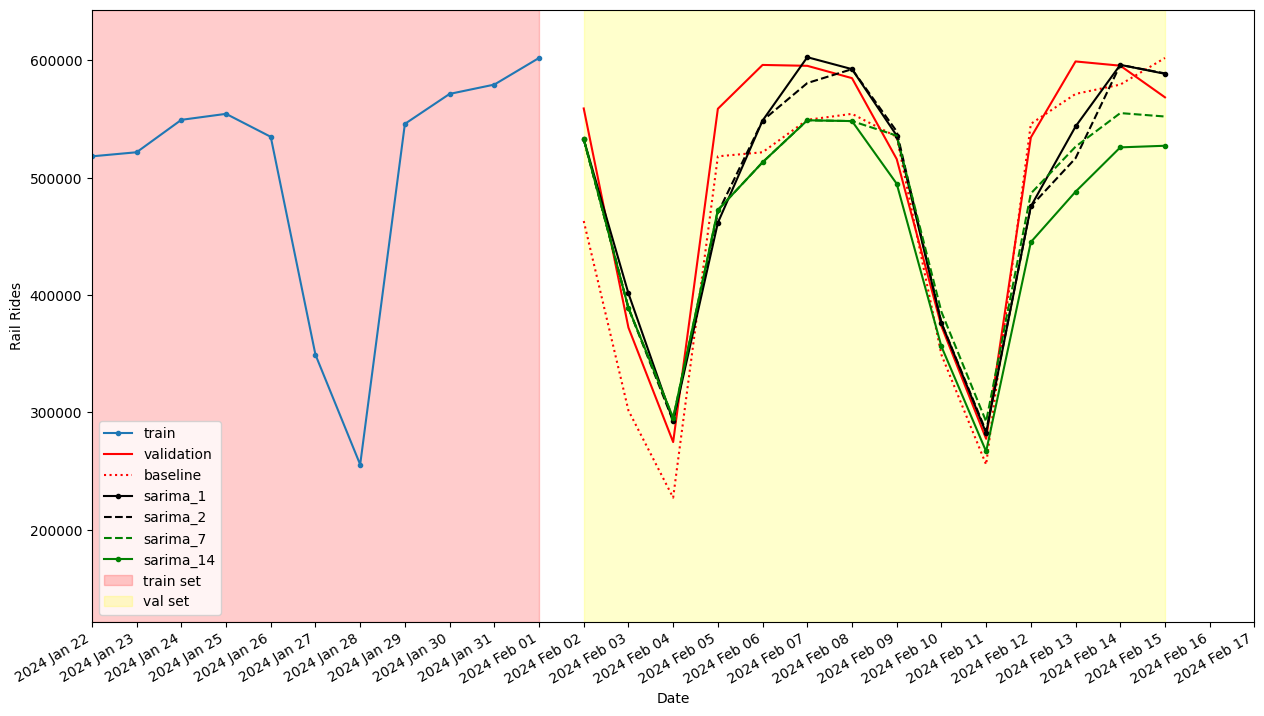

In [66]:
# Visualize the predictions
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(train_set.bus, ".-", label="train")
ax.plot(bus_preds.bus, "r-", label="validation")
ax.plot(bus_preds.last14values, "r:", label="baseline")
ax.plot(bus_preds.SARIMA_1, "k.-", label="sarima_1")
ax.plot(bus_preds.SARIMA_2, "k--", label="sarima_2")
ax.plot(bus_preds.SARIMA_7, "g--", label="sarima_7")
ax.plot(bus_preds.SARIMA_14, "g.-", label="sarima_14")

ax.set_xlabel('Date')
ax.set_ylabel('Rail Rides')

ax.axvspan(train_set_start, train_set_end, color='red', alpha=0.2, label="train set") # Train set
ax.axvspan(val_set_start, val_set_end, color='yellow', alpha=0.2, label="val set") # Val set


start_date = train_set_end - timedelta(10)
end_date = val_set_end + timedelta(2)

# Zoom
plt.xlim(xmin=start_date, xmax=end_date)



plt.xticks(pd.date_range(start=start_date, end=end_date, freq="D", inclusive='both'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b %d'))

ax.legend()
fig.autofmt_xdate()
plt.tight_layout;

In [67]:
from sklearn.metrics import mean_squared_error

In [73]:
## Bus

bus_mse_baseline = mean_squared_error(bus_preds.bus, bus_preds.last14values, squared=False)
bus_mse_sarima_1 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_1, squared=False)
bus_mse_sarima_2 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_2, squared=False)
bus_mse_sarima_7 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_7, squared=False)
bus_mse_sarima_14 = mean_squared_error(bus_preds.bus, bus_preds.SARIMA_14, squared=False)

bus_mse_baseline, bus_mse_sarima_1, bus_mse_sarima_2, bus_mse_sarima_7, bus_mse_sarima_14

(46575.65972310921,
 38728.157000471496,
 40475.270231841,
 45843.42258854511,
 57862.2436598441)

In [74]:
## Rail

rail_mse_baseline = mean_squared_error(rail_preds.rail, rail_preds.last14values, squared=False)
rail_mse_sarima_1 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_1, squared=False)
rail_mse_sarima_2 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_2, squared=False)
rail_mse_sarima_7 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_7, squared=False)
rail_mse_sarima_14 = mean_squared_error(rail_preds.rail, rail_preds.SARIMA_14, squared=False)

rail_mse_baseline, rail_mse_sarima_1, rail_mse_sarima_2, rail_mse_sarima_7, rail_mse_sarima_14

(17363.401551210274,
 22146.167211929485,
 25854.44964636195,
 28028.22464550653,
 34401.45842950329)

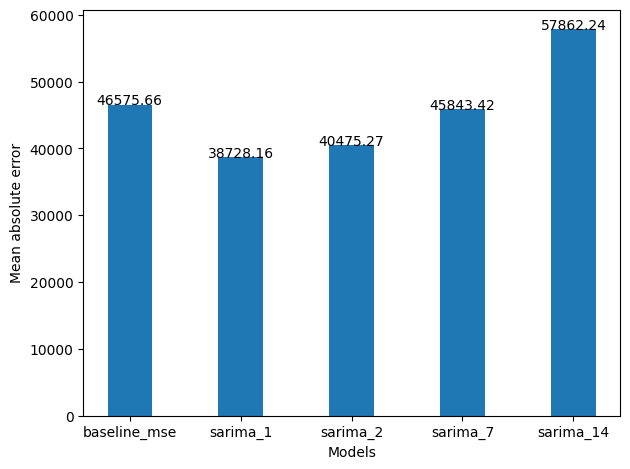

In [80]:
# Visualize
fig, ax = plt.subplots()

x = ['baseline_mse', 'sarima_1', 'sarima_2', 'sarima_7', 'sarima_14']
y = [bus_mse_baseline, bus_mse_sarima_1, bus_mse_sarima_2, bus_mse_sarima_7, bus_mse_sarima_14]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean absolute error')
# ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout();

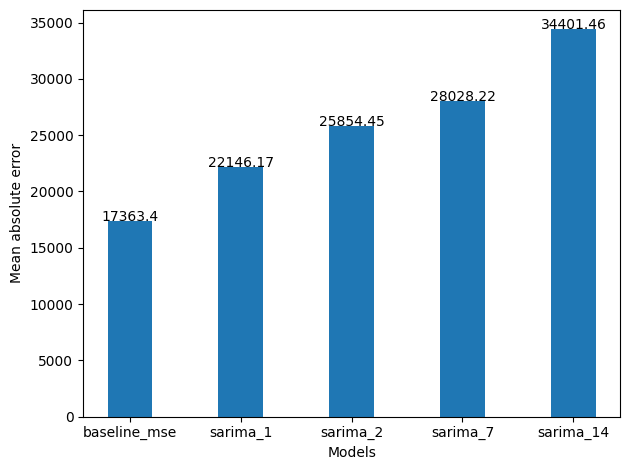

In [81]:
# Visualize
fig, ax = plt.subplots()

x = ['baseline_mse', 'sarima_1', 'sarima_2', 'sarima_7', 'sarima_14']
y = [rail_mse_baseline, rail_mse_sarima_1, rail_mse_sarima_2, rail_mse_sarima_7, rail_mse_sarima_14]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean absolute error')
# ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout();